In [32]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

EXPORT_PATH = r'C:\Users\mulla\Documents\Python\Java\project_data'
WEATHER_FOLDER = r'C:\Users\mulla\Documents\Python\Java\nc_weather'

In [9]:
%time

weather = pd.DataFrame()
for fname in Path(WEATHER_FOLDER).glob('*/*'):
    if (fname.suffix != '.csv'): 
        continue
    df = pd.read_csv(fname)
    weather = pd.concat([weather, df])

weather = weather.reset_index(drop=True)
weather.set_index('DateUTC', inplace=True)

Wall time: 0 ns


In [10]:
#Setting a benchmark value. In this case, as precipitation is normally very low, the RMSE from predicting that it is always zero should be fairly low. Resulting RMSE multiplied by 100 for ease of comparison.
weather['PrecipitationIn'] = weather['PrecipitationIn'].fillna(0)
mode_val = weather['PrecipitationIn'].mode()[0]
weather['Prediction'] = mode_val
dumbtest = np.sqrt(metrics.mean_squared_error(weather['PrecipitationIn'], weather['Prediction']))
print(dumbtest*100)

5.593124930930565


In [11]:
#At this point, there are a lot of data values that are either missing or impossible to work with for a regression model, so even before building out a model, some columns will be dropped and have
#some cleanup done. There are redundancies in the columns which should be addressed early.

#'TimeEST' and 'TimeEDT' are secondary to 'DateUTC', and furthermore both have half their values missing due to Daylight Savings Time.
#'Wind Direction' can be very helpful for a hypothetical expanded model that predicts weather across a large area, but in this specific case will not be useful as there is a numeric 'WindDirDegrees' column.
#'Events' seems to be a generalization of 'Conditions'. 'Events', appropriately mapped to numerical categories, would be simpler to work with, but 'Conditions' would likely give the better model.

#All of the above features can be dropped before even beginning to work on a model because they are inherently pointless to the stated problem, and furthermore require complicated cleanup in some cases.
#'WindDirDegrees', as an already numerical value, can be left in, but I fully expect it to have very low relevance and be removed as a result.

weather['Conditions_Num'] = weather.Conditions.map({'Mostly Cloudy':0, 'Overcast':1, 'Scattered Clouds':2, 'Partly Cloudy':3,
                                               'Clear':4,'Light Rain':5, 'Light Drizzle':6, 'Fog':7, 'Patches of Fog':8,
                                               'Rain':9,'Thunderstorm':10,'Light Thunderstorms and Rain':11,
                                               'Heavy Thunderstorms and Rain':12,'Thunderstorms and Rain':13,
                                                'Light Snow':14,'Heavy Rain':15,'Light Freezing Rain':16,'Light Freezing Drizzle':17,
                                                'Haze':18,'Drizzle':19,'Light Ice Pellets':20,'Light Freezing Fog':21,
                                               'Ice Pellets':22,'Snow':23,'Heavy Drizzle':24,'Heavy Snow':25,'Heavy Ice Pellets':26,
                                               'Shallow Fog':27,'Unknown':28})

weather['Wind SpeedMPH'] = weather['Wind SpeedMPH'].replace('Calm', 0)
weather['Gust SpeedMPH'] = weather['Gust SpeedMPH'].str.replace('-','')
weather['Wind SpeedMPH'] = pd.to_numeric(weather['Wind SpeedMPH'])
weather['Gust SpeedMPH'] = pd.to_numeric(weather['Gust SpeedMPH'])
#Gust Speed is proving to be a particularly annoying column due to the initial dataframe being filled with '-0' values that are also strings. Another fillna method is necessary here.
weather['Gust SpeedMPH'] = weather['Gust SpeedMPH'].fillna(0)
weather['Humidity'] = weather['Humidity'].fillna(weather['Humidity'].mean())

In [12]:
feature_cols = ['TemperatureF','Dew PointF','Humidity','Sea Level PressureIn','VisibilityMPH','Wind SpeedMPH','Gust SpeedMPH','Conditions_Num','WindDirDegrees']

X = weather[feature_cols]
y = weather['PrecipitationIn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [13]:
numlist = []
results = []
for num in range (1,51):
    treereg = DecisionTreeRegressor(max_depth=num,random_state=42)
    treereg.fit(X_train[feature_cols], y_train)

    treereg_predictions = treereg.predict(X_test)
    scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')

    numlist.append(num)
    results.append(np.mean(np.sqrt(-scores))*100)  #RMSE multiplied by 100 for ease of comparison with benchmark.

Text(0, 0.5, 'RMSE')

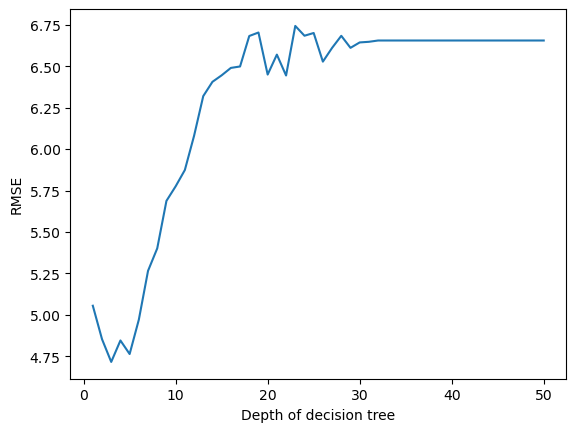

In [14]:
plt.plot(numlist, results)
plt.xlabel('Depth of decision tree')
plt.ylabel('RMSE')

In [15]:
#After testing the model on a number of max_depth values, 3 and 5 gave the best results. For the feature importance test, 5 will be chosen as the most likely indicator.
treereg = DecisionTreeRegressor(max_depth=5,random_state=42)
treereg.fit(X_train[feature_cols], y_train)

treereg_predictions = treereg.predict(X_test)
scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(np.sqrt(-scores))*100)

pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

4.7645023842449135


,feature,importance
0,TemperatureF,0.104292
1,Dew PointF,0.018868
2,Humidity,0.252103
3,Sea Level PressureIn,0.001029
4,VisibilityMPH,0.068853
5,Wind SpeedMPH,0.000000
6,Gust SpeedMPH,0.000591
7,Conditions_Num,0.553789
8,WindDirDegrees,0.000475


In [16]:
#IMPORTANT OBSERVATION: Increasing the max_depth parameter past 5 dramatically worsened the model's performance, and a key factor in this seemed to be that WindDirDegrees was being assigned 
#more and more importance. After max_depth = 10 or so, the model was performing worse than the benchmark test.

#The above model gives a slightly better result than the benchmark. Predictably, wind direction was virtually irrelevant, as was gust speed, and wind speed was not at all relevant.
#As a result of this feature importance table, all wind metrics can safely be excluded from consideration in this and future modeling.

In [17]:
feature_cols = ['TemperatureF','Dew PointF','Humidity','Sea Level PressureIn','VisibilityMPH','Conditions_Num']

X = weather[feature_cols]
y = weather['PrecipitationIn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [18]:
treereg = DecisionTreeRegressor(max_depth=5,random_state=42)
treereg.fit(X_train[feature_cols], y_train)

treereg_predictions = treereg.predict(X_test)
scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')
treereg_result = (np.mean(np.sqrt(-scores))*100)

print(treereg_result)

pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

4.732312509191859


,feature,importance
0,TemperatureF,0.104326
1,Dew PointF,0.018874
2,Humidity,0.252184
3,Sea Level PressureIn,0.001030
4,VisibilityMPH,0.068893
5,Conditions_Num,0.554693


In [19]:
#Linear Regression model.
linreg = LinearRegression()
linreg.fit(X_train[feature_cols], y_train)

linreg_predictions = linreg.predict(X_test)
scores = cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_squared_error')
linreg_result = (np.mean(np.sqrt(-scores))*100)

print(linreg_result)

60.087066128425036


In [20]:
#I did not expect Linear Regression to be at all a good model due to the imbalance in target values (most PrecipitationIn values are 0, but there are also some relative outliers that
#would inevitably over time skew a linear model horribly.) The RMSE is over 10 times that of the decision tree model, and so this model can be declared a failure.

In [21]:
%%time
#Random Forest model.
rfreg = RandomForestRegressor(min_samples_split=3,max_depth=6,n_estimators=94)
rfreg.fit(X_train[feature_cols], y_train)
scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
rfreg_result = (np.mean(np.sqrt(-scores))*100)

print(rfreg_result)

4.477964685042634
Wall time: 13.5 s


In [22]:
#Extensive looping was done to determine the best values of n_estimators, min_samples_split, and max_depth. In theory the most effective approach would be to test every combination of them at once,
#but that is a process that could take days. As a resut, hyperparameters were tested one by one, with subsequent parameters tested against the best value of the previous one. Order of testing was
#n_estimators -> max_depth -> min_samples_split

#Random Forest was the best model by a noticeable margin, providing a roughly 21% improvement over the benchmark RMSE.

In [23]:
#Other fields can be predicted as well. A potentially valuable field would be to predict categorical weather conditions based on available data, so the next model is a Logistic Regression model
#predicting 'Conditions'

#Setting the benchmark.
dumbtest_cat = weather.Conditions.value_counts()[0]/weather.shape[0]
print(dumbtest_cat)

0.3168319566838863


In [24]:
feature_cols_cat = ['TemperatureF','Dew PointF','Humidity','Sea Level PressureIn','VisibilityMPH','Wind SpeedMPH','Gust SpeedMPH','PrecipitationIn','WindDirDegrees']

X = weather[feature_cols_cat]
y = weather['Conditions']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [25]:
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
logreg_predictions = np.round(logreg.predict_proba(X_test[feature_cols_cat]), decimals=2)
print(logreg_predictions)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

                              precision    recall  f1-score   support

                       Clear       0.34      0.12      0.18       704
                     Drizzle       0.00      0.00      0.00        10
                         Fog       0.00      0.00      0.00        90
                        Haze       0.00      0.00      0.00         9
                  Heavy Rain       0.00      0.00      0.00        26
Heavy Thunderstorms and Rain       1.00      0.09      0.16        46
                 Ice Pellets       0.00      0.00      0.00         5
               Light Drizzle       0.00      0.00      0.00       126
      Light Freezing Drizzle       0.00      0.00      0.00        14
          Light Freezing Fog       0.00      0.00      0.00         3
         Light Freezing Rain       0.00      0.00      0.00        23
           Light Ice Pellets       0.00      0.00      0.00         3
                  Light Rain       0.25      0.21      0.23       574
                  L

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
#Although ultimately both the weighted precision and recall scores are slightly above the benchmark test, the logistic regression model was not overly successful in predicting weather conditions.
#Possible reasons for this are that there are a wide variety of weather conditions which are broadly similar in scope. This is a case in which either the 'events' column previously dropped could be used,
#or some manual reassignment of the various elements in 'Conditions' can be concatenated at the programmer's discretion. This will be attempted below.

In [27]:
#Suggested concatenations are as follows:
#'Mostly Cloudy', 'Overcast', and 'Partly Cloudy' will be mapped to category '30', informally dubbed 'Cloudy'
#'Scattered Clouds' and 'Clear' will be mapped to '31', informally dubbed 'Clear'
#'Light Rain','Light Drizzle','Drizzle','Rain', 'Heavy Rain', and 'Heavy Drizzle' will be mapped to '32', informally dubbed 'Rainy'
#'Fog','Patches of Fog','Shallow Fog','Haze', and 'Unknown' will be mapped to '33', informally dubbed 'Foggy.' By all rights, 'Unknown' should be dropped, but as there are only two instances of it, it is
#unlikely to impact the precision of the model appreciably.
#'Thunderstorm','Light Thunderstorms and Rain','Heavy Thunderstorms and Rain', and 'Thunderstorms and Rain' will be mapped to '34', 'Stormy'
#'Light snow','Light Freezing Rain','Light Freezing Drizzle','Light Ice Pellets','Ice Pellets', and 'Light Freezing Fog' will be mapped to '35', 'Light Cold'
#'Ice Pellets','Snow','Heavy Snow', and 'Heavy Ice Pellets' will be mapped to '36', 'Heavy Cold'


weather['Conditions_General'] = weather.Conditions.map({'Mostly Cloudy':30, 'Overcast':30, 'Scattered Clouds':31, 'Partly Cloudy':30,
                                               'Clear':31,'Light Rain':32, 'Light Drizzle':32, 'Fog':33, 'Patches of Fog':33,
                                               'Rain':32,'Thunderstorm':34,'Light Thunderstorms and Rain':34,
                                               'Heavy Thunderstorms and Rain':34,'Thunderstorms and Rain':34,
                                                'Light Snow':35,'Heavy Rain':32,'Light Freezing Rain':35,'Light Freezing Drizzle':35,
                                                'Haze':33,'Drizzle':32,'Light Ice Pellets':35,'Light Freezing Fog':35,
                                               'Ice Pellets':36,'Snow':36,'Heavy Drizzle':32,'Heavy Snow':36,'Heavy Ice Pellets':36,
                                               'Shallow Fog':33,'Unknown':33})


In [28]:
#Refitting the model.
feature_cols_cat = ['TemperatureF','Dew PointF','Humidity','Sea Level PressureIn','VisibilityMPH','Wind SpeedMPH','Gust SpeedMPH','PrecipitationIn','WindDirDegrees']

X = weather[feature_cols_cat]
y = weather['Conditions_General']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
logreg_predictions = np.round(logreg.predict_proba(X_test[feature_cols_cat]), decimals=2)
print(logreg_predictions)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

              precision    recall  f1-score   support

          30       0.62      0.98      0.76      5536
          31       0.50      0.01      0.02      2220
          32       0.49      0.15      0.23       817
          33       0.00      0.00      0.00       174
          34       0.76      0.13      0.22       218
          35       0.20      0.04      0.07        77
          36       0.00      0.00      0.00         8

    accuracy                           0.62      9050
   macro avg       0.37      0.19      0.18      9050
weighted avg       0.57      0.62      0.50      9050

[[0.69 0.29 0.   ... 0.02 0.   0.  ]
 [0.64 0.35 0.   ... 0.   0.   0.  ]
 [0.6  0.4  0.   ... 0.   0.   0.  ]
 ...
 [0.54 0.14 0.22 ... 0.04 0.   0.  ]
 [0.65 0.12 0.17 ... 0.05 0.   0.  ]
 [0.68 0.32 0.   ... 0.   0.   0.  ]]
0.6195580110497237


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

In [29]:
#Predictably, lowering the number of outcome categories dramatically increased the recall of the model. However, the new benchmark, when calculated, also drastically improved.
#The resulting model offers a less than 0.5% improvement over the new benchmark test and in this sitaution that cannot count as much of a success.
#One interesting observation is that removing wind-related data actually LOWERED the accuracy of the model slightly; this makes some sense, as wind is more directly tied to weather phenomena outside of
#precipitation; in particular, the 'Foggy' category suffered in accuracy when wind considerations were removed. 
#One significant improvement may be to find implied categories between multiple different feature interactions, which could be better represented by a Decision Tree Classifier.

In [30]:
decision_tree = DecisionTreeClassifier(max_depth=7,min_samples_split=5,random_state=42)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

          30       0.69      0.92      0.79      5536
          31       0.52      0.16      0.24      2220
          32       0.76      0.58      0.66       817
          33       0.66      0.51      0.57       174
          34       0.72      0.34      0.46       218
          35       0.71      0.73      0.72        77
          36       0.75      0.38      0.50         8

    accuracy                           0.68      9050
   macro avg       0.69      0.52      0.56      9050
weighted avg       0.65      0.68      0.63      9050

0.6795580110497238


In [31]:
#A Decision Tree classifier performed noticeably better, offering a ~7% increase in accuracy over the benchmark test. Overall, however, these models do not come as close to a desired accuracy of ~80%
#as could be hoped. As a result, the actual applicability of these models is debatable, though they do offer some value. The DT model was particularly poor for predicting clear conditions, most likely
#because they have the broadest spectrum of possible environments.

In [34]:
#KNN Classifier.
knn = KNeighborsClassifier(n_neighbors=45,p=2)
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)
print(accuracy_score(y_test, predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6424309392265193


In [35]:
#KNN performed better than the benchmark, but worse than the Decision Tree classifier. This model, however, does demonstrate that there are clusters of data points that can point a model towards a
#successful classification. With significantly more refinement and feature selection/engineering, it is likely possible to achieve an accuracy of over 75%. Curiously, using 'weighted' distance actually
#gave a marginally worse result than uniform weighting, suggesting less clustered behavior than would have been assumed.